# Richardson Verfahren

Die Theorie folgt direkt dem [iFEM](https://github.com/JSchoeberl/iFEM/blob/master/iterative/Richardson.ipynb) Jupyter-Notebook, wobei wir für das Beispiel Dirichlet Randbedingungen implementieren.

## Fixpunkt Iteration

Sei $C$ eine reguläre Matrix und $\alpha\in\mathbb{R}^+$ ein Dämpfungsfaktor. Dann ist das lineare Gleichungssystem äquivalent zur Fixpunktgleichung

$$x = x + \alpha\, C^{-1}\,(b-A x).$$ (eq:RichardsonFixpunktGleichung)

Daraus ergibt sich die Fixpunkt Iteration, auch *einfache Iteration* oder *Richardson Iteration* genannt:

$$x_{k+1} = x_k + \alpha\, C^{-1}\,(b-A x_k)$$

wobei der Startwert $x_0$ gegeben ist.

Sei $x$ eine Lösung von {eq}`eq:RichardsonFixpunktGleichung` und

$$e_k = x_k - x$$

der Iterationsfehler. Dann gilt für den neuen Fehler

$$\begin{split}
e_k & = x_{k+1}-x = x_k + \alpha\, C^{-1} (b - A\,x_k) - x\\
& = (x_k-x) + \alpha\, C^{-1} (A\,x-A\,x_k)\\
& = (\mathbb{1} - \alpha\,C^{-1} A)\, (x_k-x)\\
& = (\mathbb{1} - \alpha\,C^{-1} A)\, e_k.\\
\end{split}$$

Der neue Fehler ergibt sich durch die Iterationsmatrix oder Fehlerübergangsmatrix

$$M = (\mathbb{1} - \alpha\,C^{-1} A)$$

als

$$e_{k+1} = M\, e_k.$$

Sei $\|\cdot\|$ eine beliebige Vektornorm und

$$|\!|\!|M|\!|\!|:=\sup_{x\in\mathbb{R}^n}\frac{\|M x\|}{\|x\|}$$

die zugehörige Matrixnorm (Operatornorm vgl. {eq}`eq:operatornorm`). Damit gilt für den neuen Fehler (vgl. {eq}`eq:operatornormungleichung`)

$$\|e_{k+1}\| \le |\!|\!|M|\!|\!|\, \|e_k\|.$$

Hinreichend für die Konvergenz ist damit die Existenz einer Matrixnorm mit

$$|\!|\!|M|\!|\!|<1.$$

## Vorkonditionierer

Die Matrix $C$ wird **Vorkonditionierer** (**Preconditioner**) genannt. Sie soll zwei Eigenschaften erfüllen:
* Die Matrix-Vektormultiplikation mit $C^{-1}\cdot r$ soll billig sein.
* Die Matrix $C$ soll eine gute Approximation zu $A$ sein.

Zur Wahl der Matrix $C$
* Wählt man zum Beispiel $C = \mathbb{1}$ oder etwas besser $C = \mathop{diag} A$, dann ist die Operation $C^{-1}\cdot r$ sehr billig. Die Approximation $C \approx A$ kann aber schlecht sein.
* Wählt man hingegen $C = A$ und $\alpha = 1$, dann ist die zweite Eigenschaft best-möglich erfüllt:

  $$M = \mathbb{1} - \alpha C^{-1} A = \mathbb{1} - A^{-1}A = 0.$$
  
  Es gilt daher $\|M\| = 0$.
  
  Die Invertierung von $C$ ist jetzt aber genau das ursprüngliche Problem.
  
Ziel ist es Vorkonditionierer mit beiden Eigenschaften zu finden.

## Richardson Iteration

Im Richardson Verfahren wird die Matrix $C=\mathbb{1}$ gesetzt. Damit folgt für die Fehlerübergangsmatrix

$$M = \mathbb{1} - \alpha A.$$

Für die Überprüfung der Konvergenz gibt es zwei Möglichkeiten:

* den Konvergenzradius zu überprüfen

  $$\rho(\mathbb{1} - \alpha A) = \max_{\lambda\in\sigma(\mathbb{1} - \alpha A)} |\lambda| < 1$$
  
* eine geeignete Norm $\|\cdot\|$ finden, so dass die Matrixnorm

  $$|\!|\!|\mathbb{1} - \alpha A|\!|\!|:=\sup_{x\in\mathbb{R}^n}\frac{\|(\mathbb{1} - \alpha A) x\|}{\|x\|} < 1$$
  
  erfüllt ist.

### Optimieren des Dämpfungsfaktors

Sei $A$ symmetrisch und positiv definit. Damit sind die Eigenwerte $\sigma(A) = \{\lambda_i\in\mathbb{R}\}$ mit $0<\lambda_1 \le \lambda_2 \ldots \le \lambda_n$.

Die Eigenwerte der Fehlerübergangsmatrix $M = \mathbb{1} - \alpha\,A$ sind in dem Fall gegeben durch $\{1-\alpha\, \lambda_i\}$. Wenn wir daher

$$0 < \alpha < \frac{2}{\lambda_n}$$

wählen, folgt $\rho(M) < 1$ und damit eine konvergente Itertation.

Der Spektralradius von $M$ ist gegeben durch

$$\rho(M) = \max_i \{|1-\alpha\,\lambda_i|\} = \max \{1-\alpha \lambda_1, -(1-\alpha\,\lambda_n)\}.$$

Das Maximum ist minimiert, wenn wir $\alpha$ optimal wählen, daher

$$1-\alpha \lambda_1 = -(1-\alpha\,\lambda_n).$$

Somit sei

$$\alpha_{opt} = \frac{2}{\lambda_1+\lambda_n},$$

was zur optimalen Konvergenzrate

$$\rho_{opt} = \frac{\lambda_n-\lambda_1}{\lambda_n+\lambda_1} \approx 1 - \frac{\lambda_1}{\lambda_n} = 1 - \frac{1}{\kappa(A)}$$

führt, wobei mit $\kappa(A)$ die Konditionszahl $\kappa(A) = \lambda_{\max}(A) / \lambda_{\min}(A)$ bezeichnet sei.

Nach $N$ Iterationen ist der Fehler um den Faktor

$$\left(1-\frac{1}{\kappa}\right)^N$$

reduziert. Um die Fehlerreduktion $\epsilon$ zu erreichen, sind

$$N = \frac{\log \epsilon}{\log(1-1/\kappa)} \approx \kappa |\log \epsilon|$$

Iterationen notwendig.

## Anwendung auf Modellproblem

Wir wenden das Verfahren auf das Modellproblem

$$\begin{split}
-\Delta u + 10\, u & = 1\quad x\in\Omega = [0,1]^2\\
u & = 0\quad x \in \partial\Omega\end{split}$$

an.

In [1]:
from netgen.geom2d import unit_square
from ngsolve import *
from ngsolve.webgui import Draw
import matplotlib.pyplot as plt
from myst_nb import glue

Diskretierung der schwachen Gleichung mit FEM 1. Ordnung:

In [2]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))
fes = H1(mesh, order=1, dirichlet='bottom|right|top|left')
u,v = fes.TnT()
a = BilinearForm(grad(u)*grad(v)*dx+10*u*v*dx).Assemble()
f = LinearForm(1*v*dx).Assemble()
gfu = GridFunction(fes)

Wir nutzen das CSR Modul von `scipy` um das reduzierte Problem für die freien Freiheitsgrade zu lösen.

In [3]:
import scipy.sparse as sp
import numpy as np
from numpy.linalg import norm

Für die reduzierte Systemmatrix folgt

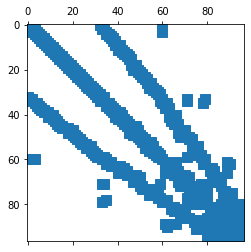

In [4]:
rows,cols,vals = a.mat.COO()
ind = np.arange(fes.ndof)[np.array(fes.FreeDofs())]

# Reduktion auf die freien Freiheitsgrade der Systemmatrix
A = sp.csr_matrix((vals,(rows,cols)))
A = A[np.ix_(ind,ind)]
plt.spy(A)
plt.show()

# Reduktion auf die freien Freiheitsgrade der rechten Seite
fd = np.array(f.vec)[ind]

Eine Approximation der Dämpfung wird mit Hilfe von ein paar Potenziterationen bestimmt:

In [5]:
hv = np.random.rand(ind.shape[0])
hv2 = np.zeros_like(hv)
hv /= norm(hv)
for k in range(20):
    hv2 = A@hv
    rho = norm(hv2)
    print(rho)
    hv = 1/rho*hv2

2.1628070258337675
4.324804945912049
4.698322104634248
4.889059116993658
5.02081367131536
5.12106768817359
5.201338340985771
5.26782538589384
5.3242075064514065
5.372754543980921
5.4149217450807
5.451700162063397
5.483821454291814
5.51187210929737
5.536353133699955
5.557708747798446
5.576338768378301
5.592603324614979
5.606824638952369
5.619288210544863


Richardson Verfahren anwenden

In [6]:
alpha = 1 / rho
sol = np.zeros(fes.ndof)
err0 = norm(fd)
its = 0
errs = []
while True:
    r = fd - A * sol[ind]
    err = norm(r)
    errs.append(err)
    #print ("iteration", its, "res=", err)
    sol[ind] += alpha * r
    if err < 1e-8 * err0 or its > 10000: break
    its = its+1
print ("needed", its, "iterations")

needed 386 iterations


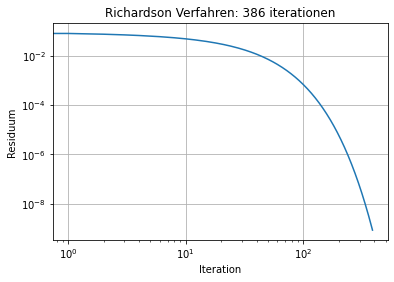

In [7]:
fig, ax = plt.subplots()
ax.loglog(errs)
ax.grid()
ax.set_title('Richardson Verfahren: '+str(its)+' iterationen')
ax.set_xlabel('Iteration')
ax.set_ylabel('Residuum')
glue("FEM_RichardsonVerfahren_fig", fig, display=False)

Schreiben wir die Lösung wieder zurück in die `GridFunction` von `ngsolve` können wir die Lösung visualisieren:

In [8]:
gfu.vec[:] = sol
Draw(gfu,mesh,'u')

WebGuiWidget(value={'ngsolve_version': '6.2.2104-121-gee6902d12', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, '…

BaseWebGuiScene